In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
import seaborn as sns
import warnings

# ignore warnings
warnings.filterwarnings("ignore")

Lets start by data exploratory to gain some inspection and understanding of our dataset.

In [2]:
# load in dataset
data = pd.read_csv("Life Expectancy Data.csv")

In [3]:
print("Dataset contains rows: {}, columns: {}".format(data.shape[0],data.shape[1])) # total data size
data.head()

Dataset contains rows: 2938, columns: 22


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [4]:
# check data types
data.dtypes

Country                             object
Year                                 int64
Status                              object
Life expectancy                    float64
Adult Mortality                    float64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                        float64
Measles                              int64
 BMI                               float64
under-five deaths                    int64
Polio                              float64
Total expenditure                  float64
Diphtheria                         float64
 HIV/AIDS                          float64
GDP                                float64
Population                         float64
 thinness  1-19 years              float64
 thinness 5-9 years                float64
Income composition of resources    float64
Schooling                          float64
dtype: object

Lets visualize the data and get some useful information out of it. We could select

some specific columns and make an analysis on it.

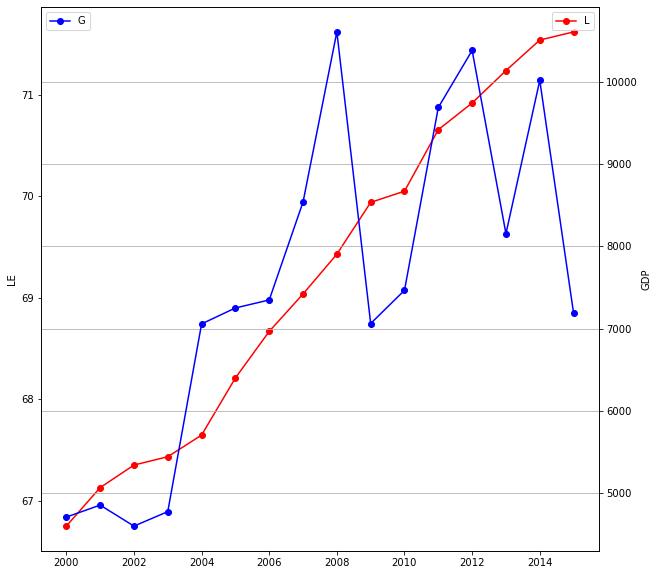

In [5]:
# See the mean of life expectancy and GDP of every country over every year
mean_le = data.groupby("Year")["Life expectancy "].mean()
mean_gdp = data.groupby("Year")["GDP"].mean()

fig2 = plt.figure(figsize = (10,10))
ax = fig2.add_subplot()
ax2 = ax.twinx()

ax.plot(mean_le, color = 'red', marker = 'o')
ax2.plot(mean_gdp, color = 'blue', marker = 'o')

ax.set_ylabel("LE")
ax2.set_ylabel("GDP")
ax.legend("LE", loc = 1)
ax2.legend("GDP", loc = 2)
plt.xlabel("Year")
plt.grid(True)

In [6]:
# get the top 10 life ecpentancy and gdp according to the country
t10_le = data.groupby("Country")["Life expectancy "].mean().sort_values(ascending = False)[:10]
t10_le_gdp = data.groupby("Country")["GDP"].mean()[t10_le.index]

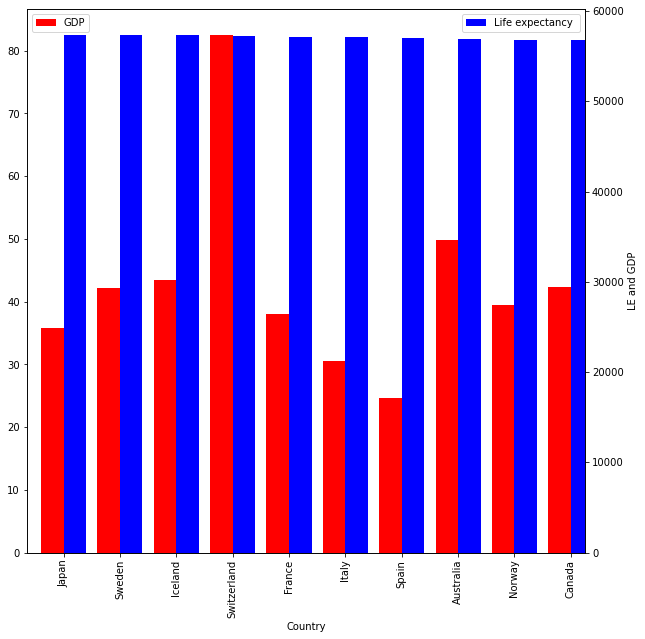

In [7]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

width = 0.4
t10_le.plot(kind = 'bar', ax = ax, color = 'blue', position = 0, width = width)
t10_le_gdp.plot(kind = 'bar', ax = ax2, color = 'red', position = 1, width = width)
plt.xlabel("Country")
plt.ylabel("LE and GDP")

ax.legend(loc = 1)
ax2.legend(loc = 2)
plt.show()

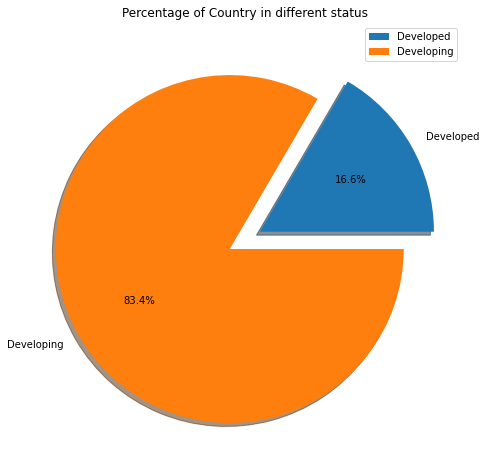

In [8]:
# Check the distribution of developed and developing country
developed_country_cnt = len(data[data.Status == "Developed"]["Country"].unique())
developing_country_cnt = len(data[data.Status == "Developing"]["Country"].unique())
status_cnt = [developed_country_cnt, developing_country_cnt]

# plot pie chart
exploder = [0.1, 0.1]
plt.figure(figsize = (8,8))
plt.title("Percentage of Country in different status")
plt.pie(status_cnt, labels = ["Developed", "Developing"],
        explode = exploder, shadow = True, autopct = '%1.1f%%')
plt.legend()
plt.show()

Now we can start by handling the missing values aka nan values.

In [9]:
print("Missing Column Value Percentage\n")
missing_value = []
for col in data.columns:
    missing_pct = data[col].isnull().sum()
    if missing_pct == 0: continue
    missing_value.append(col)
    print("{} - {}%".format(col, missing_pct))

Missing Column Value Percentage

Life expectancy  - 10%
Adult Mortality - 10%
Alcohol - 194%
Hepatitis B - 553%
 BMI  - 34%
Polio - 19%
Total expenditure - 226%
Diphtheria  - 19%
GDP - 448%
Population - 652%
 thinness  1-19 years - 34%
 thinness 5-9 years - 34%
Income composition of resources - 167%
Schooling - 163%


As the missing values analysis shown above, all of the columns contain

missing values and Population contain the largest amount of missing values.

Next we could visualize them with graph.

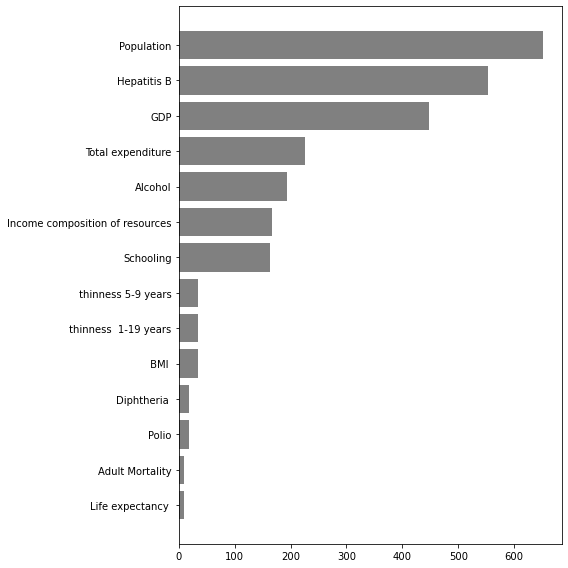

In [10]:
# plot the missing value bar
pct = np.array([data[col].isnull().sum() for col in missing_value])
sort_index = np.argsort(pct)
sort_value = np.sort(pct)
sort_col = [missing_value[index] for index in sort_index]

plt.figure(figsize = (8,8))
plt.barh(y = sort_col, width = sort_value, linewidth = 1, color = "gray")
plt.tight_layout()
plt.show()

In [11]:
# reset index
data.dropna(subset = ["Life expectancy "], inplace = True)
data.reset_index(drop = True, inplace = True)

Lets handle the missing values. Due to the small size of dataset sample, we dont simply drop

the missing rows. In this case, we get the mean value of each columns according to country and 

replace the missing values in each columns.

In [12]:
# handle missing values
def fill_mean(df):
    miss_col = data.columns[df.isnull().any()]
    for col in miss_col:
        miss_val = df[col].isnull()
        miss_index = miss_val[miss_val == True].index
        # handle according to country
        country_mean = data.groupby('Country')[col].mean()
        countries = country_mean.index
        for index,mean in enumerate(country_mean):
            country = countries[index]
            country_index = df.iloc[miss_index]['Country'][df.iloc[miss_index]['Country'] == country]
            if np.isnan(country_mean[index]):
                df[col].iloc[country_index.index] = df[col].mean()
                continue
            df[col].iloc[country_index.index] = country_mean[index]
            
    return df

In [13]:
clean_data = fill_mean(data)
clean_data.isnull().any() # check if there is any missing value

Country                            False
Year                               False
Status                             False
Life expectancy                    False
Adult Mortality                    False
infant deaths                      False
Alcohol                            False
percentage expenditure             False
Hepatitis B                        False
Measles                            False
 BMI                               False
under-five deaths                  False
Polio                              False
Total expenditure                  False
Diphtheria                         False
 HIV/AIDS                          False
GDP                                False
Population                         False
 thinness  1-19 years              False
 thinness 5-9 years                False
Income composition of resources    False
Schooling                          False
dtype: bool

Next lets perform feature selection. There are quite a number of columns here, we could filter

them out by using mutual information between x cols and y col hence select the x cols

that contribute better in the dataset.

In [14]:
def mutual_info(df):
    y = df["Life expectancy "]
    x = df.drop(columns = ["Life expectancy "], axis = 1)
    x = x.select_dtypes(exclude = "object")
    
    # calculate mi scores
    mi_scores = mutual_info_regression(x, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    print(mi_scores)
    
    # visualization
    mi_scores.plot(kind = 'bar', figsize = (12,10), colormap = 'coolwarm_r')
    return mi_scores

Adult Mortality                    1.268128
Income composition of resources    0.926052
 thinness 5-9 years                0.778935
 thinness  1-19 years              0.776526
Schooling                          0.697561
 BMI                               0.571423
 HIV/AIDS                          0.529512
infant deaths                      0.438248
under-five deaths                  0.437222
Alcohol                            0.353388
GDP                                0.352354
Polio                              0.326086
Diphtheria                         0.310241
percentage expenditure             0.297931
Hepatitis B                        0.295499
Total expenditure                  0.269235
Population                         0.154035
Measles                            0.109809
Year                               0.068313
Name: MI Scores, dtype: float64


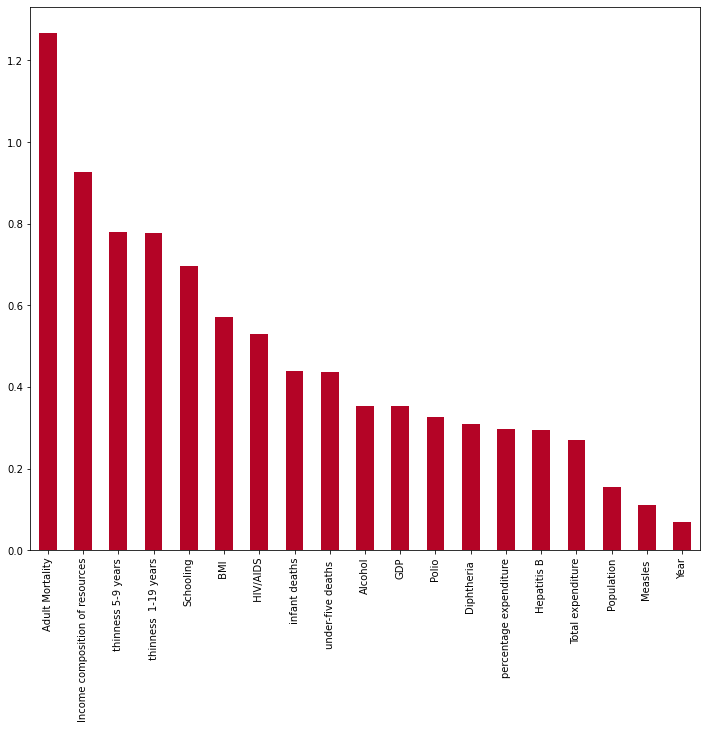

In [15]:
mi_scores = mutual_info(clean_data)

In [16]:
# eliminate low mi scores
clean_data.drop(columns = mi_scores.index[10:], inplace = True)
clean_data.head()

,Country,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,BMI,under-five deaths,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,Developing,65.0,263.0,62,0.01,19.1,83,0.1,17.2,17.3,0.479,10.1
1,Afghanistan,Developing,59.9,271.0,64,0.01,18.6,86,0.1,17.5,17.5,0.476,10.0
2,Afghanistan,Developing,59.9,268.0,66,0.01,18.1,89,0.1,17.7,17.7,0.470,9.9
3,Afghanistan,Developing,59.5,272.0,69,0.01,17.6,93,0.1,17.9,18.0,0.463,9.8
4,Afghanistan,Developing,59.2,275.0,71,0.01,17.2,97,0.1,18.2,18.2,0.454,9.5


In [17]:
y = clean_data.pop("Life expectancy ")
x = clean_data

There are categorical columns existing in our dataset. Lets convert them into non string value

by doing one hot encoding.

In [18]:
# one hot encoding
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
obj_cols = x.select_dtypes("object")
clean_data.drop(columns = obj_cols, inplace = True)

ohe_cols = ohe.fit_transform(obj_cols)
print(ohe_cols)

[[1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]]


Next, lets scale the numerical data in our dataset into a reasonable range, 0 - 1.

In [19]:
scaler = MinMaxScaler()
scale_feature = clean_data.select_dtypes(exclude = "object")
scaled = scaler.fit_transform(scale_feature)
print(scaled)

[[0.36288089 0.03444444 0.         ... 0.60350877 0.50527426 0.48792271]
 [0.37396122 0.03555556 0.         ... 0.61052632 0.5021097  0.48309179]
 [0.36980609 0.03666667 0.         ... 0.61754386 0.49578059 0.47826087]
 ...
 [0.09972299 0.01388889 0.2474804  ... 0.04210526 0.45042194 0.48309179]
 [0.94875346 0.01388889 0.09574468 ... 0.05614035 0.45042194 0.47342995]
 [0.91966759 0.01333333 0.09350504 ... 0.38947368 0.45780591 0.47342995]]


In [20]:
# append onehotencoding and scaled data
cols_name = clean_data.columns

scaled_df = pd.DataFrame(scaled, columns = cols_name)
x = pd.concat((scaled_df, pd.DataFrame(ohe_cols)),axis = 1)
x

,Adult Mortality,infant deaths,Alcohol,BMI,under-five deaths,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,...,175,176,177,178,179,180,181,182,183,184
0,0.362881,0.034444,0.000000,0.236292,0.0332,0.000000,0.619565,0.603509,0.505274,0.487923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.373961,0.035556,0.000000,0.229765,0.0344,0.000000,0.630435,0.610526,0.502110,0.483092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.369806,0.036667,0.000000,0.223238,0.0356,0.000000,0.637681,0.617544,0.495781,0.478261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.375346,0.038333,0.000000,0.216710,0.0372,0.000000,0.644928,0.628070,0.488397,0.473430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.379501,0.039444,0.000000,0.211488,0.0388,0.000000,0.655797,0.635088,0.478903,0.458937,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,1.000000,0.015000,0.243561,0.340731,0.0168,0.663366,0.336957,0.326316,0.429325,0.444444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2924,0.988920,0.014444,0.226764,0.335509,0.0164,0.724752,0.351449,0.343860,0.440928,0.458937,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2925,0.099723,0.013889,0.247480,0.330287,0.0160,0.786139,0.039855,0.042105,0.450422,0.483092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2926,0.948753,0.013889,0.095745,0.325065,0.0156,0.831683,0.054348,0.056140,0.450422,0.473430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Lets convert y into three categories.

0 - low life expectancy

1 - moderate life expectancy

2 - high life expectancy

In [21]:
# turn y into scaled output
Y = y.map(lambda value: 0 if value <= y.max()*0.5 else (
          1 if value > y.max()*0.5 and value <= y.max()*0.8 else 2))
Y.unique()

array([1, 2, 0], dtype=int64)

Lets split the data into train and test and start building our model for training.

In [22]:
# split train and test
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size = 0.1, random_state = 10)

Perform Cross Validation to select the parameter C - the tolerance for misclassification value

In [48]:
# define parameter
param_grid = {
    'C' : [1,5,10,20],
    'gamma' : ['auto','scale']
}

#cross validation - 10 folds for cv
svc = SVC(kernel = "rbf")
GSC = GridSearchCV(svc, param_grid, cv = 10)
GSC.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [1, 5, 10, 20], 'gamma': ['auto', 'scale']})

In [49]:
scores = []
scores.append({
    'model': "RandomForest",
    'best_score': GSC.best_score_,
    'best_params': GSC.best_params_
})

score_df = pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])
score_df.head()

,model,best_score,best_params
0,RandomForest,0.955981,"{'C': 20, 'gamma': 'scale'}"


The result from the grid search cross validation shows that parameter c with 20 and gamma with scale 

obtained the best result hence we will use the same settings to build our final model and train it.

In this case, we will try Boosting and Bagging and algorithms along with  Support Vector Machine

and select the best algorithm that return highest score.

In [52]:
svc = SVC(C = 20, gamma = "scale", kernel = "rbf")
ADA = AdaBoostClassifier(svc, n_estimators = 10, algorithm = 'SAMME', learning_rate = 1.0)
BAG = BaggingClassifier(svc, n_estimators = 5, max_samples = 0.5)

In [53]:
ADA.fit(x_train, y_train)
BAG.fit(x_train, y_train)

BaggingClassifier(base_estimator=SVC(C=20), max_samples=0.5, n_estimators=5)

In [54]:
from sklearn.metrics import accuracy_score

y_pred_ada = ADA.predict(x_test)
y_pred_bag = BAG.predict(x_test)
print("Boosting Accuracy : {}\nBagging Accuracy : {}".format(accuracy_score(y_test,y_pred_ada),
                                                             accuracy_score(y_test,y_pred_bag)))

Boosting Accuracy : 0.7952218430034129
Bagging Accuracy : 0.9419795221843004


As the accuracy result shown above, bagging seems to have better result as compared

to boosting, so it wil be our final model.